# Intro to Selecting and Processing Raster Data

This workflow introduces how to search for, acquire and process raster data efficiently. Specfically, we demonstrate finding [Sentinel-2](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2) satellite imagery relevant for an area and time, in this case, a time range of a few months in 2024 over the National Institute of Technology (NIT) in Goa, India.

Note: some portions of this notebook are inspired by the [Introduction to Geospatial Raster and Vector Data with Python course](https://carpentries-incubator.github.io/geospatial-python/index.html).


## Main Objectives

- **Visualize vector data and select an AOI**: Plot vector data to narrow in on a specific area to retrieve data for.
- **Access Sentinel-2 data**: Locate and retrieve relevant Sentinel-2 data for the specific area and timeframe via STAC.
- **Inspect and visualize raster data**: Examine metadata, including projections, bands, dimensions no data pixels. Plot raster data correctly.
- **Process multi-spectral raster data**: Work with vector data to establish bounds, manage coordinate systems, and set up the area of interest (AOI).
- **Interpret time-series raster data**: Learn to explore the time dimension for raster data and search for temporal patterns.
- **Cloud masking and compositing**: Handle clouds and create composites from multiple image scenes.
- **Speed up raster processing with Dask**: Learn how to optimize raster processing steps using a parallel processing library.


At the end, you'll be able to efficiently process raster imagery for a region and time of interest!

In [1]:
import dask
import geopandas as gpd
import odc.stac
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pystac_client
import rasterio
import requests
import rioxarray
import time
import xarray as xr
from lonboard import viz
from pyproj import CRS
from rasterio.features import rasterize
from shapely.geometry import box, Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

## Accessing raster data

First let's start by reading in a [vector dataset containing a subnational administrative polygons for India](https://data.humdata.org/dataset/geoboundaries-admin-boundaries-for-india?). We will use this to obtain geographic bounds to select and acquire raster data.

In [2]:
admin_boundaries_gdf = gpd.read_file("https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/IND/ADM1/geoBoundaries-IND-ADM1_simplified.geojson")

We'll need to convert the coordinate reference system (CRS) to the projection that is used to load web map tiles and store coordinate metadata in the STAC catalog. Here we convert from EPSG:32759 (UTM zone 59S) to EPSG:4326 (WGS 84).

In [3]:
admin_boundaries_gdf = admin_boundaries_gdf.to_crs(epsg="4326") # convert from UTM to WGS84

We can plot the full dataset.

In [4]:
viz(admin_boundaries_gdf)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

Let's focus on one region, Goa.

In [5]:
admin_boundary_goa_gdf = admin_boundaries_gdf[admin_boundaries_gdf.shapeName == 'Goa']

In [6]:
admin_boundary_goa_gdf

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
28,Goa,IN-GA,1811400B6111924962807,IND,ADM1,"POLYGON ((73.67538 15.72702, 73.68020 15.72537..."


The LULC subset is located in the following region of Vanuatu.

In [7]:
viz(admin_boundary_goa_gdf)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

Now let's actually search for and retrieve some raster data. 

In [8]:
# Get the bounds of the administrative polygon to define the AOI
aoi = admin_boundary_goa_gdf.total_bounds  # (minx, miny, maxx, maxy)

In [9]:
aoi

array([73.67538205, 14.90064174, 74.33649919, 15.80076264])

The [STAC browser](https://radiantearth.github.io/stac-browser/#/?.language=en) is a great place for exploring available datasets, offering an up-to-date overview of existing STAC catalogs. From the list, we can select the ["Earth Search" catalog](https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/?.language=en), which serves as the entry point for accessing the archive of Sentinel-2 images hosted on AWS.

When you open a catalog in the STAC browser, the API URL can be found by clicking the “Source” button in the upper right corner. This URL provides access to the catalog's content, and if the catalog supports it, enables item search functionality. For the Earth Search STAC catalog, the API URL is:

In [10]:
# Access AWS STAC for Sentinel-2 Data
aws_stac_url = "https://earth-search.aws.element84.com/v1"

# You can query a STAC API endpoint from Python using the pystac_client library:
stac_client = pystac_client.Client.open(aws_stac_url)

In the following steps, we request scenes from the Sentinel-2 L2A collection, which contains Sentinel-2 data products pre-processed to Level 2A (bottom-of-atmosphere reflectance) and stored in Cloud Optimized GeoTIFF (COG) format.

> Cloud Optimized GeoTIFFs (COGs) are standard GeoTIFF files with additional features that make them highly suitable for cloud computing and web-based applications. Building on the widely-used GeoTIFF format (introduced in Episode 1: Introduction to Raster Data), COGs have a special internal structure. One key feature is that COGs organize data into “blocks,” allowing users to remotely access specific portions of the file via independent HTTP requests, rather than downloading the entire file. Additionally, COGs often include multiple lower-resolution versions of the image, known as "overviews," which can be accessed separately. This pyramidal structure enables users who don't need full high-resolution details to quickly retrieve lower-resolution versions, significantly reducing download times. More details about the COG format are available here.

We specifically search for all available Sentinel-2 scenes in the `sentinel-2-l2a` collection that meet the following conditions:
- intersect with a given bounding box (based on the boundaries of the administrative boundary);
- were captured between January 1, 2024, and October 31, 2024;
- have less than 5% cloud cover;
- have less than 25% invalid pixels.

In [11]:
s2_search = stac_client.search(
    collections=["sentinel-2-l2a"], # Sentinel-2, Level 2A, Cloud Optimized GeoTiffs (COGs)
    bbox=list(aoi),
    datetime="2024-01-01/2024-10-31",
    query={"eo:cloud_cover": {"lt": 5}, "s2:nodata_pixel_percentage": {"lt": 25}},
)

Note: At this point, we are only working with metadata, so no actual images will be downloaded yet. However, metadata alone can become quite large if many scenes meet the search criteria! Therefore, it's possible to set a limit on the number of search results.

In [12]:
# Retrieve all items (still just metadata) from search results
s2_items = s2_search.item_collection()

We execute the query to determine how many scenes meet our search criteria (note that this result may vary as more data is continually added to the catalog):

In [13]:
print(s2_search.matched())

56


Which should equate to the number of items collected:

In [14]:
len(s2_items)

56

That's a lot of scenes! Let's reduce the size of our AOI to a 10 kilometre bounding box surrounding NIT Goa.

In [15]:
nit_goa = gpd.GeoSeries([Point(74.012241, 15.169161)], crs="EPSG:4326").to_crs(f"+proj=aeqd +lat_0=15.2993 +lon_0=74.1240 +units=m")

In [68]:
viz(nit_goa)

/Users/lillythomas/.pyenv/versions/3.9.0/envs/py39b/lib/python3.9/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

In [17]:
aoi = nit_goa.buffer(1000).to_crs("EPSG:4326").total_bounds

In [18]:
s2_search = stac_client.search(
    collections=["sentinel-2-l2a"], # Sentinel-2, Level 2A, Cloud Optimized GeoTiffs (COGs)
    bbox= list(aoi),
    datetime="2024-01-01/2024-10-31",
    query={"eo:cloud_cover": {"lt": 5}, "s2:nodata_pixel_percentage": {"lt": 25}},
)

In [19]:
print(s2_search.matched())

10


That's a more managable number of image scenes. Let's work with this.

In [20]:
# Retrieve all items (still just metadata) from search results
s2_items = s2_search.item_collection()

Each item includes details such as the scene's geometry, acquisition time, and additional metadata, which can be accessed in dictionary format via the properties attribute.

Let’s take a closer look at the metadata for the first item in the search results:

In [21]:
item = s2_items[0]
print(item.datetime)
print(item.geometry)
print(item.properties)

2024-04-23 05:44:57.385000+00:00
{'type': 'Polygon', 'coordinates': [[[73.13672047883799, 15.369336034409695], [73.14522001709557, 14.377141983932997], [74.16335648754064, 14.382932405548878], [74.15952041550737, 15.375544542571744], [73.13672047883799, 15.369336034409695]]]}
{'created': '2024-04-23T13:46:37.857Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 0.777811, 'proj:epsg': 32643, 'mgrs:utm_zone': 43, 'mgrs:latitude_band': 'P', 'mgrs:grid_square': 'CS', 'grid:code': 'MGRS-43PCS', 'view:sun_azimuth': 94.0458936528455, 'view:sun_elevation': 70.77460810146499, 's2:degraded_msi_data_percentage': 0, 's2:nodata_pixel_percentage': 0, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 0.015833, 's2:cloud_shadow_percentage': 0.003789, 's2:vegetation_percentage': 6.720386, 's2:not_vegetated_percentage': 3.246993, 's2:water_percentage': 89.16387, 's2:unclassified_percentage': 0.071317, 's2:medium_proba_clouds

Until now, we have only focused on metadata—so how do we access the actual satellite images of a scene (referred to as “assets” in STAC terminology)? These images can be accessed through the links provided in the item's assets attribute.

In [22]:
assets = s2_items[0].assets  # first item's asset dictionary
print(assets.keys())

dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])


We can display a brief description of the available assets:

In [23]:
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

aot: Aerosol optical thickness (AOT)
blue: Blue (band 2) - 10m
coastal: Coastal aerosol (band 1) - 60m
granule_metadata: None
green: Green (band 3) - 10m
nir: NIR 1 (band 8) - 10m
nir08: NIR 2 (band 8A) - 20m
nir09: NIR 3 (band 9) - 60m
red: Red (band 4) - 10m
rededge1: Red edge 1 (band 5) - 20m
rededge2: Red edge 2 (band 6) - 20m
rededge3: Red edge 3 (band 7) - 20m
scl: Scene classification map (SCL)
swir16: SWIR 1 (band 11) - 20m
swir22: SWIR 2 (band 12) - 20m
thumbnail: Thumbnail image
tileinfo_metadata: None
visual: True color image
wvp: Water vapour (WVP)
aot-jp2: Aerosol optical thickness (AOT)
blue-jp2: Blue (band 2) - 10m
coastal-jp2: Coastal aerosol (band 1) - 60m
green-jp2: Green (band 3) - 10m
nir-jp2: NIR 1 (band 8) - 10m
nir08-jp2: NIR 2 (band 8A) - 20m
nir09-jp2: NIR 3 (band 9) - 60m
red-jp2: Red (band 4) - 10m
rededge1-jp2: Red edge 1 (band 5) - 20m
rededge2-jp2: Red edge 2 (band 6) - 20m
rededge3-jp2: Red edge 3 (band 7) - 20m
scl-jp2: Scene classification map (SCL)
swi

Among the various assets, there are multiple raster files (each corresponding to an optical band captured by the multi-spectral instrument), a thumbnail, a true-color image ("visual"), instrument metadata, and scene classification data ("SCL"). Let's retrieve the URLs for these assets:

In [24]:
print(assets["thumbnail"].href)

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/43/P/CS/2024/4/S2A_43PCS_20240423_0_L2A/thumbnail.jpg


Remote raster data can be accessed directly using the `rioxarray` library. 

In [25]:
nir_href = assets["nir"].href
nir = rioxarray.open_rasterio(nir_href)
print(nir)

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 88kB 1.7e+06 1.7e+06 1.7e+06 ... 1.59e+06 1.59e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0


We can then save the raster data to a file on disk:

In [26]:
# save whole image to disk
#nir.rio.to_raster("nir.tif")

Since processing large rasters can be time-consuming (for example, the 10-meter NIR band has over 100 million pixels), it's often more efficient to work with a smaller subset of the data. Fortunately, because the raster is in Cloud Optimized GeoTIFF (COG) format, we can download just the portion we need! 

In this case, we specify that we want to download the first band in the TIFF file and extract a subset by slicing the width and height dimensions.

In [27]:
# save portion of an image to disk
#nir[0,1500:2200,1500:2200].rio.to_raster("nir_subset.tif")

## Reading raster data

In this section, we cover the core principles, tools, and metadata/raster attributes necessary for handling raster data in Python. We will also explore how Python manages missing or invalid data values.

The `rioxarray` library will be our primary tool for working with raster data in this lesson. It builds upon the functionality of `rasterio` (a package for working with raster data) and `xarray` (for multi-dimensional arrays). By extending `xarray`, `rioxarray` adds higher-level functions, such as `open_rasterio` for loading raster datasets, and provides additional methods to `xarray` objects like `Dataset` and `DataArray`. These methods, available through the `rio` accessor, become accessible in `xarray` once `rioxarray` is imported.

We will also use the `pystac` library to load raster data from the search results produced earlier.

For demonstration, we'll focus on the first scene and load the `nir09` band (with a central wavelength of 945 nm). This can be done by using the `rioxarray.open_rasterio()` function, and retrieving the band through its Hypertext Reference (`href`, or URL).

In [28]:
raster_goa_b9 = rioxarray.open_rasterio(s2_items[0].assets["nir09"].href)

In a Jupyter notebook, simply calling the variable name allows us to quickly inspect the shape and attributes of the dataset. This provides an immediate overview of the data structure and key metadata.

In [29]:
raster_goa_b9

<xarray.DataArray (band: 1, y: 1830, x: 1830)> Size: 7MB
[3348900 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 15kB 3e+05 3.001e+05 ... 4.097e+05 4.098e+05
  * y            (y) float64 15kB 1.7e+06 1.7e+06 1.7e+06 ... 1.59e+06 1.59e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

The initial call to `rioxarray.open_rasterio()` retrieves the file from either local or remote storage, returning a `xarray.DataArray`. This object is assigned to a variable like `raster_vanu_b9`. While using `xarray` also returns a `xarray.DataArray`, it won’t include the geospatial metadata (such as projection details). You can apply NumPy functions or Python’s math operators to a `xarray.DataArray` just as you would with a NumPy array. Displaying the `DataArray` variable shows its metadata.

The output indicates that the data is a `xarray.DataArray` with 1 band, 1830 rows, and 1830 columns. It also shows the total pixel count and their type, which is an unsigned integer (`uint16`). The `DataArray` stores spatial coordinates (x and y) and band information, with each having its own data type—`float64` for spatial coordinates and `int64` for bands.

In addition, the `DataArray` contains attributes such as `.rio.crs`, `.rio.nodata`, and `.rio.bounds()` that store the file’s metadata. Most metadata can be accessed directly as attributes (e.g., `.rio.crs`), but methods like `.rio.bounds()` require parentheses to retrieve the information.

In [30]:
print(raster_goa_b9.rio.crs)
print(raster_goa_b9.rio.nodata)
print(raster_goa_b9.rio.bounds())
print(raster_goa_b9.rio.width)
print(raster_goa_b9.rio.height)

EPSG:32643
0
(300000.0, 1590240.0, 409800.0, 1700040.0)
1830
1830


The Coordinate Reference System for `raster_goa_b9.rio.crs` is given as the string `EPSG:32643`. The no-data value is set to `0`, and the bounding box corners of our raster are provided by the output of `.bounds()` in a tuple (similar to a list but immutable). The height and width correspond to what we observed when we printed the DataArray; however, we can also retrieve these dimensions using `.rio.width` and `.rio.height` if we need them for calculations.

## Visualizing raster data

After viewing the attributes of our raster, we can examine the raw values of the array with `.values`:

In [31]:
raster_goa_b9.values

array([[[ 546,  520,  521, ..., 2654, 2470, 2409],
        [ 558,  575,  565, ..., 2557, 2594, 2420],
        [ 524,  568,  589, ..., 2418, 2642, 2702],
        ...,
        [ 582,  567,  577, ...,  969, 1066, 1156],
        [ 583,  568,  577, ...,  935,  959,  998],
        [ 577,  578,  577, ...,  985,  951,  923]]], dtype=uint16)

This provides a quick glimpse of the values in our array, but only at the corners. Because our raster is loaded in Python as a `DataArray` type, we can plot it in a single line, similar to how we would with a pandas DataFrame, using `DataArray.plot()`.

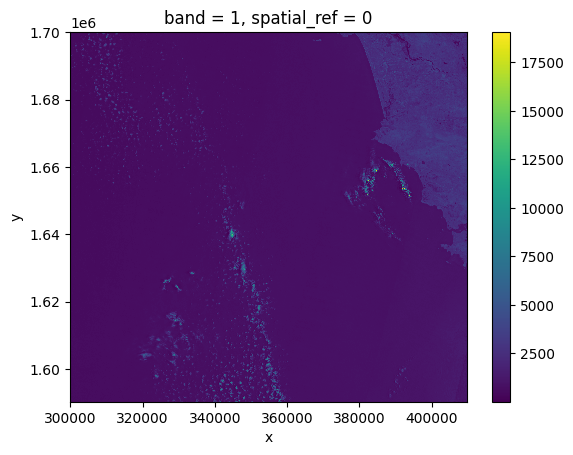

In [32]:
raster_goa_b9.plot()

Observe that `rioxarray` conveniently enables us to plot this raster with spatial coordinates on the x and y axes, which is not the default behavior for many other functions or libraries.

The plot displays the satellite measurement of the spectral band `nir09` for an area encompassing the AOI. According to the Sentinel-2 documentation, this band has a central wavelength of 945 nm, making it sensitive to water vapor, and it offers a spatial resolution of 60 m. It's important to note that the `band=1` in the image title refers to the order of the bands in the `DataArray`, not the Sentinel-2 band number 09 that we encountered in the `pystac` search results.

From a quick glance at the image, we can see that cloudy pixels exhibit high reflectance values, whereas the contrast of other areas is relatively low. This behavior is expected due to the band's sensitivity to water vapor. However, if better color contrast is desired, one can include the option `robust=True`, which displays values between the 2nd and 98th percentiles.

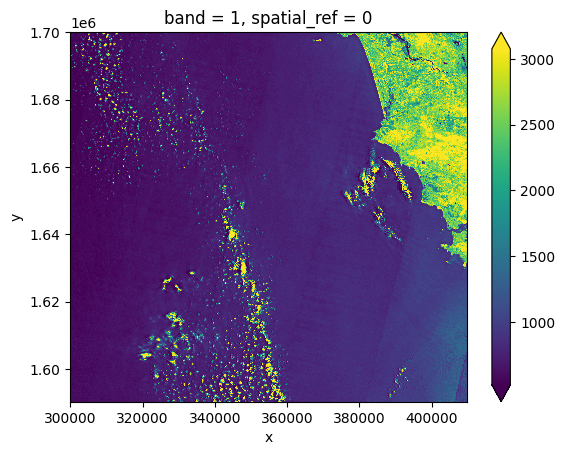

In [33]:
raster_goa_b9.plot(robust=True)

This feature allows us to adjust the color limits to better accommodate most of the values in the image, providing a clearer view of the ground pixels.

The `robust=True` option automatically restricts the displayed values to those between the 2nd and 98th percentiles. However, this approach may not be suitable for all situations. For a tailored display range, you can also manually set the `vmin` and `vmax` parameters. For instance, you can plot values between 100 and 7000:

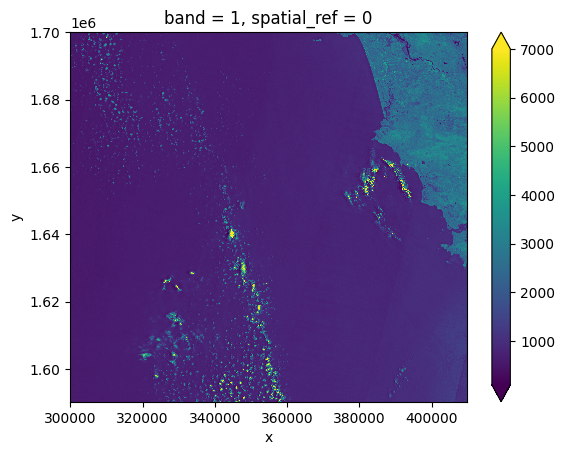

In [34]:
raster_goa_b9.plot(vmin=100, vmax=7000)

## Deciphering the Raster Coordinate Reference System (CRS)

Another important piece of information we want to examine is the Coordinate Reference System (CRS), which can be accessed using `.rio.crs`. We will explore how the characteristics of the CRS are represented in our data file and their significance. To view the CRS string associated with our DataArray's `rio` object, we can utilize the `crs` attribute.

In [35]:
print(raster_goa_b9.rio.crs)

EPSG:32643


EPSG codes effectively provide a concise representation of specific coordinate reference systems. However, if we wish to obtain more detailed information about the CRS, such as the units, we can utilize the ``pyproj`` library, which is designed for representing and working with coordinate reference systems.

In [36]:
epsg = raster_goa_b9.rio.crs.to_epsg()
crs = CRS(epsg)
crs

<Projected CRS: EPSG:32643>
Name: WGS 84 / UTM zone 43N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°E and 78°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Maldives. Pakistan. Russian Federation. Tajikistan.
- bounds: (72.0, 0.0, 78.0, 84.0)
Coordinate Operation:
- name: UTM zone 43N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The ``CRS`` class from the ``pyproj`` library enables us to create a CRS object that includes methods and attributes for retrieving specific information about a CRS, as well as the detailed summary mentioned earlier.

One especially valuable attribute is ``area_of_use``, which indicates the geographic boundaries for which the CRS is designed to be applied.

In [37]:
crs.area_of_use

AreaOfUse(west=72.0, south=0.0, east=78.0, north=84.0, name='Between 72°E and 78°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Maldives. Pakistan. Russian Federation. Tajikistan.')

In [38]:
# More on the various attributes accessible for the CRS class can be viewed with the following:
# help(crs)

Let’s break down the components of the ``pyproj`` CRS summary. The string encompasses all the individual elements of the CRS that Python or other GIS software may require, organized into distinct sections and datum.

The projection name is ``UTM zone 43N`` (the UTM system comprises 60 zones, each spanning 6 degrees of longitude). The underlying datum is ``WGS84``. **Axis Info**: the CRS utilizes a Cartesian coordinate system with two axes, ``easting`` and ``northing``, measured in meters. **Area of Use**: the projection is applicable for a specific range of longitudes, from ``72°E`` to ``78°E``, in the northern hemisphere (from ``84.0°N`` to ``0.0°N``). **Coordinate Operation**: this describes how the coordinates are projected (if applicable) onto a Cartesian (``x``, ``y``) plane. The ``Transverse Mercator`` projection is effective for regions with narrow longitudinal widths, which is why distinct UTM zones exist. **Datum**: this section provides details about the datum, which serves as the reference point for coordinates. ``WGS 84`` is a widely used datum. It's important to note that the zone is specific to the UTM projection, and not all CRSs will have a designated zone.

## Calculate Raster Statistics
Knowing the minimum and maximum values of a raster dataset can be valuable. We can obtain these and other descriptive statistics, such as minimum, maximum, mean, and standard deviation.

In [39]:
print(raster_goa_b9.min())
print(raster_goa_b9.max())
print(raster_goa_b9.mean())
print(raster_goa_b9.std())

<xarray.DataArray ()> Size: 2B
array(1, dtype=uint16)
Coordinates:
    spatial_ref  int64 8B 0
<xarray.DataArray ()> Size: 2B
array(19067, dtype=uint16)
Coordinates:
    spatial_ref  int64 8B 0
<xarray.DataArray ()> Size: 8B
array(997.62025381)
Coordinates:
    spatial_ref  int64 8B 0
<xarray.DataArray ()> Size: 8B
array(717.57343508)
Coordinates:
    spatial_ref  int64 8B 0


The information provided includes a report of the minimum, maximum, mean, and standard deviation values, as well as the data type. If we want to view specific quantiles, we can utilize xarray's `.quantile()` method. For instance, to calculate the 25% and 75% quantiles:

In [40]:
print(raster_goa_b9.quantile([0.25, 0.75]))

<xarray.DataArray (quantile: 2)> Size: 16B
array([661., 899.])
Coordinates:
  * quantile  (quantile) float64 16B 0.25 0.75


## Dealing with Missing Data
So far, we have visualized a band from a Sentinel-2 scene and computed its statistics. However, we need to consider missing data. Raster datasets often include a "no data value," which `rioxarray` refers to as `nodata`. This value is assigned to pixels where data is absent or not collected. Various situations can lead to missing data, and other values in the raster may indicate different issues. A common example is missing data along the edges of rasters.

By default, the shape of a raster is always rectangular. Therefore, if a dataset has a non-rectangular shape, some pixels at the edges will contain no data values. This situation often arises when data are collected by a sensor that only covered part of a defined region.

As noted earlier, the `nodata` value for this dataset (`raster_goa_b9.rio.nodata`) is 0. When we plotted the band data or calculated statistics, the missing values were not differentiated from the actual data. This oversight can lead to unexpected results; for instance, the 25th percentile we calculated was 435, indicating that there is little to no missing data in the raster.

To clearly distinguish missing data from valid data, one approach is to use `nan` to represent them. This can be achieved by specifying `masked=True` when loading the raster:

In [41]:
raster_goa_b9 = rioxarray.open_rasterio(s2_items[0].assets["nir09"].href, masked=True)

You can also utilize the `where` function to filter out all the pixels that differ from the raster's `nodata` value:

In [42]:
raster_goa_b9.where(raster_goa_b9!=raster_goa_b9.rio.nodata)

<xarray.DataArray (band: 1, y: 1830, x: 1830)> Size: 13MB
array([[[ 546.,  520.,  521., ..., 2654., 2470., 2409.],
        [ 558.,  575.,  565., ..., 2557., 2594., 2420.],
        [ 524.,  568.,  589., ..., 2418., 2642., 2702.],
        ...,
        [ 582.,  567.,  577., ...,  969., 1066., 1156.],
        [ 583.,  568.,  577., ...,  935.,  959.,  998.],
        [ 577.,  578.,  577., ...,  985.,  951.,  923.]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 15kB 3e+05 3.001e+05 ... 4.097e+05 4.098e+05
  * y            (y) float64 15kB 1.7e+06 1.7e+06 1.7e+06 ... 1.59e+06 1.59e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    scale_factor:        1.0
    add_offset:          0.0

Both methods will convert the `nodata` value from 0 to `nan`. Now, when we recalculate the statistics, the missing data will be excluded. Additionally, you can use the `.values` attribute with the statistical functions to obtain only the calculated values, without any of the object metadata.

In [43]:
print(raster_goa_b9.min().values)
print(raster_goa_b9.max().values)
print(raster_goa_b9.mean().values)
print(raster_goa_b9.std().values)

1.0
19067.0
997.6203
717.57355


It's important to note that using `nan` instead of 0 to represent missing data has a side effect: the data type of the `DataArray` changes from integers to floats. This should be considered when the data type is significant for your application.

## Incorporating multiple bands 

Up to this point, we have examined a single-band raster, specifically the `nir09` band of a Sentinel-2 scene. However, to obtain a smaller, non-georeferenced version of the scene, one might also wish to visualize the true-color overview of the area. This overview is offered as a multi-band raster, which is a raster dataset that includes multiple bands.

The overview asset in the Sentinel-2 scene is a multi-band asset. Like the `nir09` band, we can load it using:

In [44]:
raster_goa_overview = rioxarray.open_rasterio(s2_items[0].assets['visual'].href, overview_level=3)
raster_goa_overview

<xarray.DataArray (band: 3, y: 687, x: 687)> Size: 1MB
[1415907 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 5kB 3.001e+05 3.002e+05 ... 4.096e+05 4.097e+05
  * y            (y) float64 5kB 1.7e+06 1.7e+06 1.7e+06 ... 1.59e+06 1.59e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

When reading GeoTIFFs using the `open_rasterio()` function, the band number appears first. In the `xarray.DataArray` object, we can observe that the shape is now `(band: 3, y: 687, x: 687)`, indicating three bands in the band dimension. It's always advisable to check the shape of the raster array you are working with to ensure it meets your expectations. Many functions, particularly those used for plotting images, require the raster array to have a specific shape. You can also verify the shape using the `.shape` attribute:

In [45]:
raster_goa_overview.shape

(3, 687, 687)

You can visualize the multi-band data using the `DataArray.plot.imshow()` function:

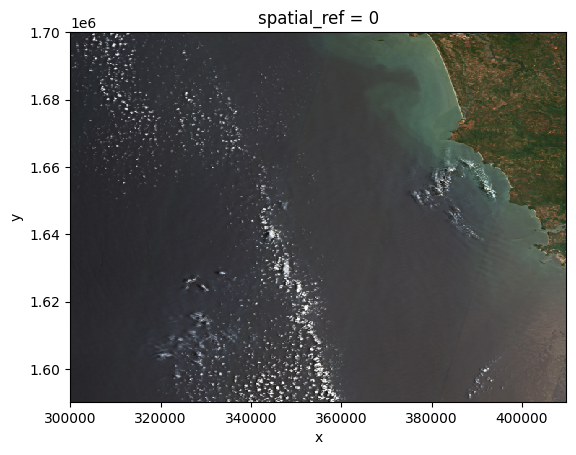

In [46]:
raster_goa_overview.plot.imshow()

Keep in mind that the `DataArray.plot.imshow()` function assumes the input `DataArray` has three channels, which corresponds to the RGB colormap. It is not compatible with image arrays that contain more than three channels. However, you can create a false-color image by substituting one of the RGB channels with another band.

As illustrated in the figure above, the true-color image appears stretched. To visualize it with the correct aspect ratio, you can refer to the documentation for `DataArray.plot.imshow()`.

Given that the height-to-width ratio is 1:1 (as confirmed by the `rio.height` and `rio.width` attributes), we can set the aspect ratio to 1. For instance, you might set the size to 5 inches and specify `aspect=1`. Note that when using the `aspect` argument, you must also provide a size, as stated in the `DataArray.plot.imshow()` documentation.

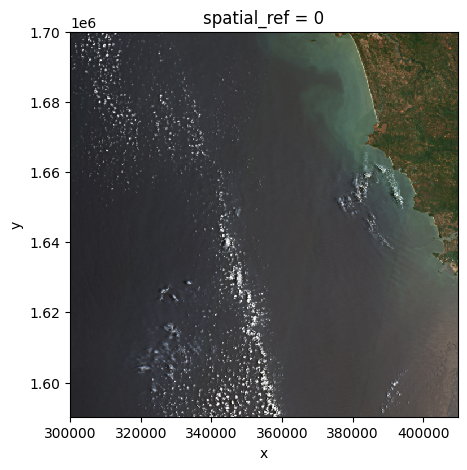

In [47]:
raster_goa_overview.plot.imshow(size=5, aspect=1)

Now let's say we want to work with not just the visual bands, but also some of the others, such as the `nir` band. We'll introduce a new tool and method for loading raster data from STAC into an `xarray.Dataset` called [Open Data Cube (ODC)](https://www.opendatacube.org/) which we imported as `odc`. 

`odc` features an extension for working with raster data from STAC-compliant catalogues. We will use this to more robustly work with the Sentinel-2 data that we queried for earlier.

In the following cell, we do the following:

1. **`s2_data = odc.stac.load(...)`**:
   - This line uses the `odc` library to load data from the Sentinel-2 items we collected metadata for. The `load` function retrieves the actual raster data.

2. **`items=s2_items`**:
   - The `s2_items` refers to the Sentinel-2 items (scenes) we retrieved earlier from the STAC catalog search. These items contain the metadata and location of the relevant Sentinel-2 data, which will be loaded in this step.

3. **`bands=["red", "green", "blue", "nir", "scl"]`**:
   - This specifies the spectral bands to load: Red, Green, Blue, and Near-Infrared (NIR). These are common bands used for analyzing land cover, vegetation health, and generating RGB images. We also include a band that isn't a necessary a wavelength range, but rather a classification layer (SCL) which we will use to know where cloudy pixels are.

4. **`bbox=aoi`**:
   - The `bbox` argument defines the **Area of Interest (AOI)**, which is the geographic bounding box of the region we want to load data for (same one as used earlier). The AOI is given as a list of coordinates that define the AOI's extent: `[min_longitude, min_latitude, max_longitude, max_latitude]`. 

5. **`progress=tqdm`**:
   - The `progress` argument links the loading process to `tqdm`, which provides a progress bar. This is useful when loading large datasets, as it shows how much data has been loaded and gives an indication of how long the process might take.


**IMPORTANT:** 
When provided a `bbox` argument, `odc` will automatically clip the generated raster to the bounds of the provided extent. This means we only return the pixels that we are actually interested in!

The result, `s2_data`, is a `xarray.Dataset` that we can use for further analysis, such as visualization or classification.

In [48]:
# item_limit = 2

s2_data = odc.stac.load(
    items=s2_items, #[:item_limit],
    bands=["red", "green", "blue", "nir", "scl"],
    bbox=aoi,
    progress=tqdm,
)

  0%|          | 0/50 [00:00<?, ?it/s]

The `odc.stac.load()` function returns an `xarray.Dataset` instead of an `xarray.DataArray` because we are loading more than one spectral band (`["red", "green", "blue", "nir", "scl"]`). A `xarray.Dataset` is designed to hold a single variable (or band) of data. Since we are loading multiple bands, the function returns a `xarray.Dataset`, which is essentially a collection of `DataArray`s, where each `DataArray` corresponds to one of the requested bands. A `xarray.Dataset` can be thought of as a container for multiple `DataArray`s. It can hold multiple variables (e.g., bands like `red`, `green`, `blue`, `nir`), each with the same or different dimensions and coordinates. In this case, each band (e.g., `red`, `green`, etc.) is a separate `DataArray` within the `Dataset`.

The **xarray.Dataset** structure allows you to work with multiple related variables (e.g., bands) in the same space, with shared coordinates (such as `latitude`, `longitude`, and `time`). This makes it easier to perform operations that involve multiple bands, such as stacking them together to create a RGB image or performing multi-band analysis.

If you were loading only a single band, the `odc.stac.load()` function could return a `DataArray`, which is more suited to holding a single variable with associated dimensions and coordinates. However, because we requested multiple bands, a `xarray.Dataset` is the appropriate return type.

Note also that we are also limiting the number of items computed to two, for the sake of execution time.

In [49]:
s2_data

<xarray.Dataset> Size: 4MB
Dimensions:      (y: 201, x: 202, time: 10)
Coordinates:
  * y            (y) float64 2kB 1.678e+06 1.678e+06 ... 1.676e+06 1.676e+06
  * x            (x) float64 2kB 3.929e+05 3.929e+05 ... 3.949e+05 3.949e+05
    spatial_ref  int32 4B 32643
  * time         (time) datetime64[ns] 80B 2024-01-14T05:44:47.972000 ... 202...
Data variables:
    red          (time, y, x) uint16 812kB 744 675 644 696 ... 718 961 882 648
    green        (time, y, x) uint16 812kB 614 606 597 567 ... 724 777 747 678
    blue         (time, y, x) uint16 812kB 350 400 364 312 ... 425 444 436 392
    nir          (time, y, x) uint16 812kB 2244 2098 1850 ... 2170 2236 2244
    scl          (time, y, x) uint8 406kB 5 5 5 5 4 4 4 4 4 ... 4 4 4 4 5 5 4 4

Notice that the time dimension is automatically interpreted and correctly lines up with the number of items we set the limit to. This means we have the same number of items overlapping the AOI from different image captures with different timestamps. `odc` doesn't assume we want to do any manipulation by default on the time dimension so it returns the dataset with the items stacked in a time series.

In order to plot this image, let's composite the image over time, to produce a temporal depth of 1 where pixels represent an average of all of the timestamps.

In [50]:
s2_data_composite = s2_data.mean(dim='time')

Notice the new shape of the dataset:

In [51]:
s2_data_composite

<xarray.Dataset> Size: 2MB
Dimensions:      (y: 201, x: 202)
Coordinates:
  * y            (y) float64 2kB 1.678e+06 1.678e+06 ... 1.676e+06 1.676e+06
  * x            (x) float64 2kB 3.929e+05 3.929e+05 ... 3.949e+05 3.949e+05
    spatial_ref  int32 4B 32643
Data variables:
    red          (y, x) float64 325kB 1.106e+03 1.2e+03 ... 838.4 623.4
    green        (y, x) float64 325kB 949.3 1.011e+03 956.1 ... 653.0 582.4
    blue         (y, x) float64 325kB 799.2 820.8 729.9 ... 464.3 432.7 367.6
    nir          (y, x) float64 325kB 2.03e+03 2.015e+03 ... 2.083e+03 2.015e+03
    scl          (y, x) float64 325kB 5.3 5.3 5.2 5.2 4.9 ... 4.5 4.5 4.3 4.3

Also notice here that the aspect ratio is not perfectly 1:1, but close enough for use with a 1:1 aspect ratio when plotting. We can plot a true color image from the dataset by specifying the necessary bands.

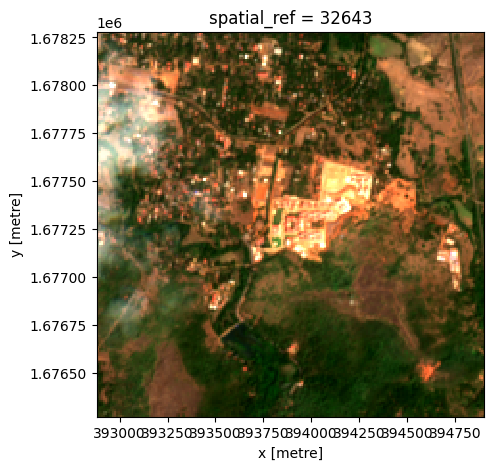

In [52]:
s2_data_composite[["red", "green", "blue"]].to_array("band").plot.imshow(rgb="band", robust=True, size=5, aspect=1)

We can also plot any single band from the dataset like so:

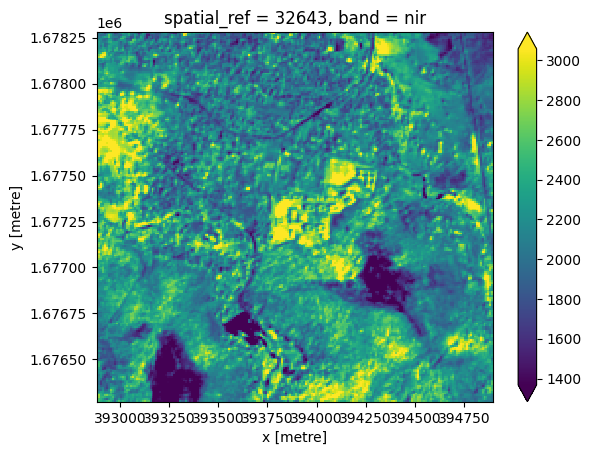

In [53]:
s2_data_composite[["nir"]].to_array("band").plot(robust=True)

Let's say we want to take a look at the time series for a single band. We can do this by taking the average in the spatial dimensions (x and y) for each timestamp and plotting the values.

In [54]:
s2_data_mean_time_series = s2_data.mean(dim=["y", "x"])

Then we can extract the time series for one of bands. Near infrared is interesting because it is useful in determing seasonal phenology.

In [55]:
nir_time_series = s2_data_mean_time_series["nir"]

We can plot a line plot for the near infrared averages for each timestamp.

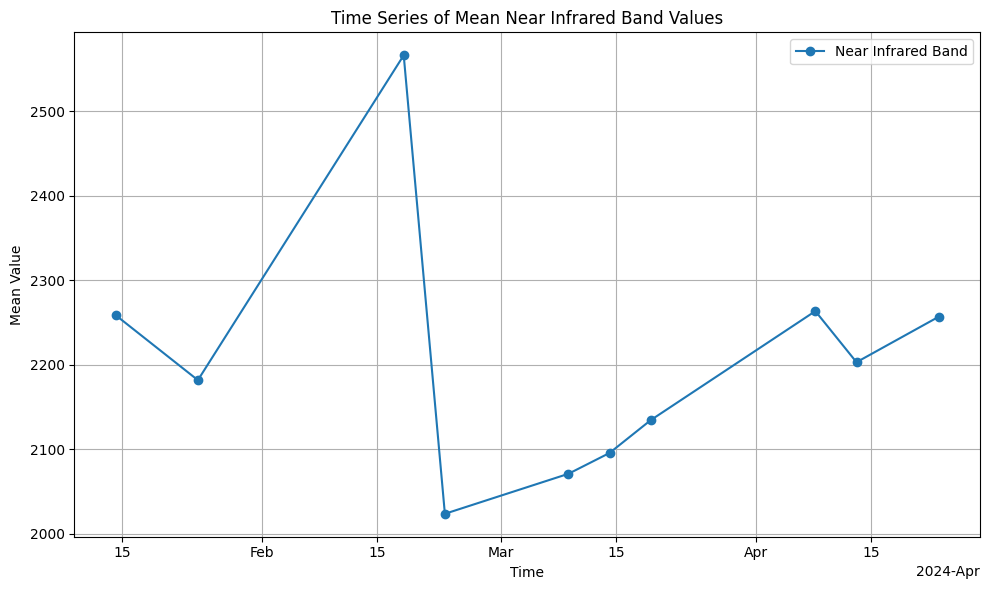

In [56]:
plt.figure(figsize=(10, 6))
nir_time_series.plot(label='Near Infrared Band', marker='o')

plt.title("Time Series of Mean Near Infrared Band Values")
plt.xlabel("Time")
plt.ylabel("Mean Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Dealing with cloudy pixels

To mask out clouds from Sentinel-2 data, we can use the 'SCL' (Scene Classification Layer) band, which includes cloud information. The SCL band classifies each pixel in the Sentinel-2 image, including cloud-related classes such as cloud shadows, medium-probability clouds, high-probability clouds, and cirrus clouds. By masking out these classes, we can remove cloud-covered pixels from the dataset.

First we need to declare the cloud-related SCL classes. The common classes for clouds are:

> Cloud Shadows: 3
>
> Low probability clouds: 7
>
> Medium probability clouds: 8
> 
> High probability clouds: 9
> 
> Thin cirrus: 10

In order to mask out these cloud classes, we'll a boolean mask using `xarray`'s `.isin()` method.


In [57]:
cloud_classes = [3, 7, 8, 9, 10]  # Cloud-related SCL classes
cloud_mask = s2_data['scl'].isin(cloud_classes)

Now, we will use the cloud mask to filter out cloud-covered pixels in the red, green, blue, and NIR bands.

In [58]:
masked_s2_data = s2_data[['red', 'green', 'blue', 'nir']].where(~cloud_mask, drop=False)  # Keep all pixels

In [59]:
masked_s2_data

<xarray.Dataset> Size: 6MB
Dimensions:      (time: 10, y: 201, x: 202)
Coordinates:
  * y            (y) float64 2kB 1.678e+06 1.678e+06 ... 1.676e+06 1.676e+06
  * x            (x) float64 2kB 3.929e+05 3.929e+05 ... 3.949e+05 3.949e+05
    spatial_ref  int32 4B 32643
  * time         (time) datetime64[ns] 80B 2024-01-14T05:44:47.972000 ... 202...
Data variables:
    red          (time, y, x) float32 2MB 744.0 675.0 644.0 ... 882.0 648.0
    green        (time, y, x) float32 2MB 614.0 606.0 597.0 ... 747.0 678.0
    blue         (time, y, x) float32 2MB 350.0 400.0 364.0 ... 436.0 392.0
    nir          (time, y, x) float32 2MB 2.244e+03 2.098e+03 ... 2.244e+03

Let's plot the cloud-free data to verify the results. To do this, let's composite the imagery again to get a temporal average.

In [60]:
masked_s2_data_composite = masked_s2_data.mean(dim='time')

Now we can plot an image.

/Users/lillythomas/.pyenv/versions/3.9.0/envs/py39b/lib/python3.9/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


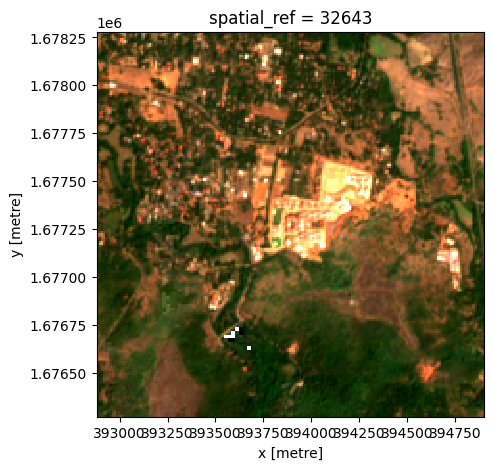

In [61]:
masked_s2_data_composite[['red', 'green', 'blue']].to_array("band").plot.imshow(rgb="band", robust=True, size=5, aspect=1)

The image plot is looking a bit over-exposed. Let's adjust the value ranges to better fit the raster data.

/Users/lillythomas/.pyenv/versions/3.9.0/envs/py39b/lib/python3.9/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


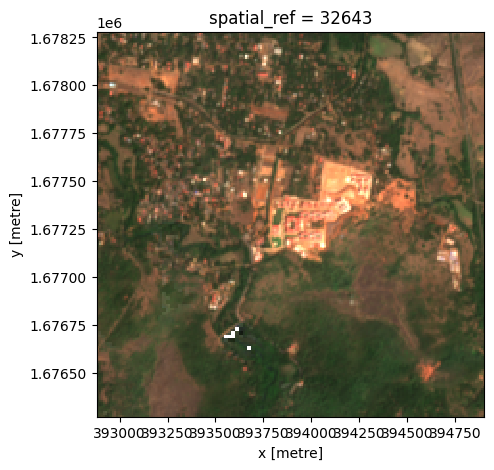

In [62]:
masked_s2_data_composite[['red', 'green', 'blue']].to_array("band").plot.imshow(rgb="band", robust=True, size=5, aspect=1, vmin=0, vmax=2000)

That looks pretty good! Now we have a cloud-masked composite. We can use this to get a clearer signal of near infrared over time.

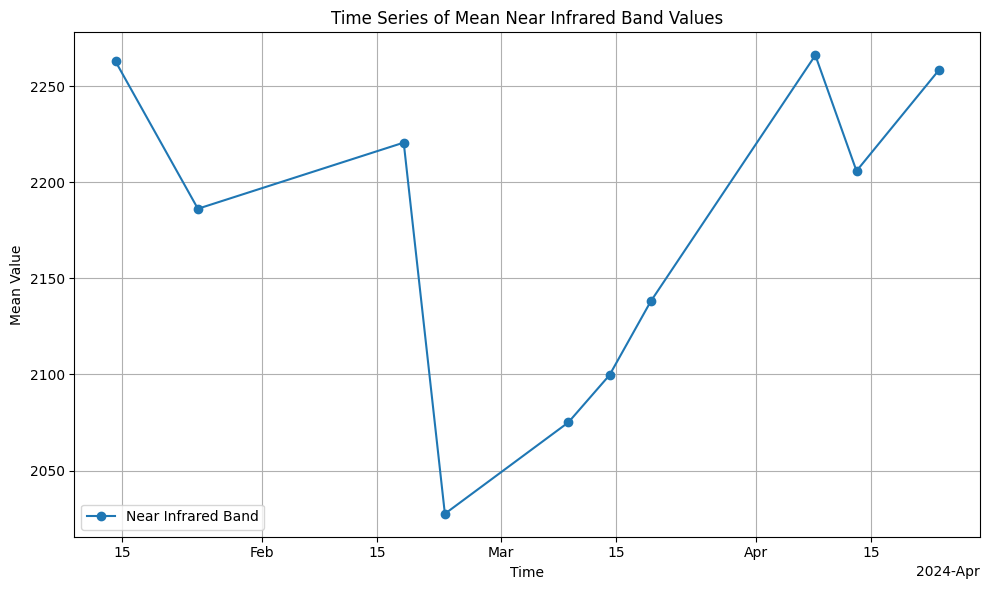

In [63]:
masked_s2_data_mean_time_series = masked_s2_data.mean(dim=["y", "x"])
masked_nir_time_series = masked_s2_data_mean_time_series["nir"]
plt.figure(figsize=(10, 6))
masked_nir_time_series.plot(label='Near Infrared Band', marker='o')

plt.title("Time Series of Mean Near Infrared Band Values")
plt.xlabel("Time")
plt.ylabel("Mean Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

What if we want to interpolate where the cloudy pixels are for each timestamp, however, instead of reducing to a single temporal composite? We can do this using the cloud mask and an interpolation (e.g. linear, nearest neighbor, spline) method on either the spatial (x and y) dimension or time. Combinations of these will imply different overhead and thus varying run times, as we will see.

For this example, we will interpolate on the temporal dimension. For the following, we need to get the cloud mask, this time actually changing the values for cloudy pixels to `NaN`:

In [64]:
cloudy_pixels = s2_data[['red', 'green', 'blue', 'nir']].where(~cloud_mask, other=np.nan)

We will then introduce a new library, `dask`, which is used to parallelize expensive operations by chunking data into smaller parts and distributing those across available workers. Here, we select a chunk size based on the shape of the `DataArray`. The chunk size is a factor that is specific to the size of your data and should closely match any internal tiling paramaters if relevant (as is the case for COGs).  

We will apply downsampling to further reduce the computation time. In practice, you might not want to downsample your data if spatial resolution is very important, but here we do so for the purposes of a quick example. Note that in the downsampling step `coarsen()` we provide `x=4, y=4` which specifies the size of the neighborhood over which to average. In this case, it will average every 4 pixels along the x-axis and every 4 pixels along the y-axis. We also include `boundary='trim'` which determines how the edges of the DataArray are handled. With `boundary='trim'`, any excess pixels that do not fit into the averaging windows are removed from the result. For example, if the dimensions of `cloudy_pixels` are not exact multiples of 4, the excess pixels at the edges will be discarded. Lastly, `.mean()` is the coarse operation, calling `.mean()` computes the mean value of each coarse block defined by the `coarsen()` method. This results in a new `DataArray` with a lower spatial resolution, where each pixel represents the average value of a 4x4 block of pixels from the original `cloudy_pixels`.

On the interpolation algorithm, we use one of the faster options, nearest neighbors. It's less accurate than alternatives like linear because it samples from a small number of adjacent pixels, but that's what also makes it relatively faster.

Let's start with benchmarking time to run without chunking using `dask`.

In [65]:
%%time

downsampled_s2_data = cloudy_pixels.coarsen(x=4, y=4, boundary='trim').mean()
interpolated_downsampled = downsampled_s2_data.interpolate_na(dim='time', method='nearest') 

CPU times: user 247 ms, sys: 3.61 ms, total: 250 ms
Wall time: 250 ms


Now, let's chunk the data along the spatial dimensions. We don't want to chunk on the time dimension, so we tell `dask` to leave that dimension alone. Dask treats `-1` as a special flag that means "do not chunk" or "use the full length of this dimension as a single chunk." Essentially, `-1` is a shorthand to tell Dask that you want to keep the entire dimension in one piece.

In [66]:
%%time

cloudy_pixels_chunked = cloudy_pixels.chunk({'x': 1024, 'y': 1024, 'time': -1})
downsampled_s2_data = cloudy_pixels_chunked.coarsen(x=4, y=4, boundary='trim').mean()
interpolated_downsampled_chunked = downsampled_s2_data.interpolate_na(dim='time', method='nearest') 

CPU times: user 57.9 ms, sys: 6.01 ms, total: 64 ms
Wall time: 63 ms


Much faster! Let's plot a result for one of the timestamps.

/Users/lillythomas/.pyenv/versions/3.9.0/envs/py39b/lib/python3.9/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


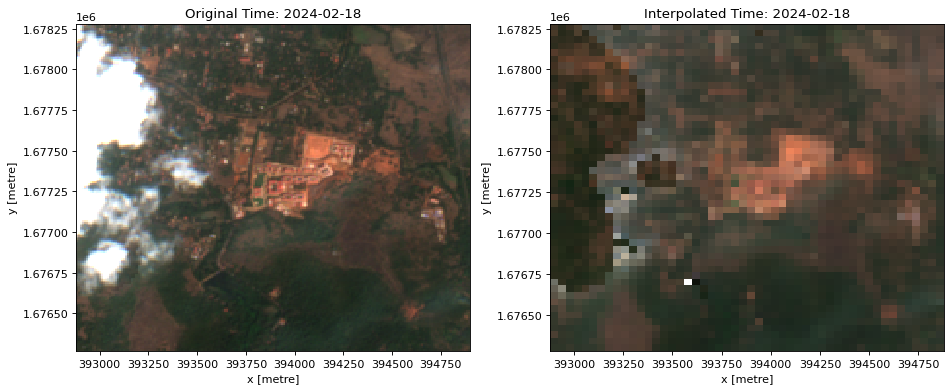

CPU times: user 1.06 s, sys: 174 ms, total: 1.23 s
Wall time: 866 ms


In [84]:
%%time

# Index of a single timestamp
i = 2

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=80)

# Original RGB image before interpolation
original_rgb = s2_data[["red", "green", "blue"]].isel(time=i)
original_rgb.to_array("band").plot.imshow(ax=axes[0], rgb='band', vmin=0, vmax=3000, add_colorbar=False)
axes[0].set_title(f'Original Time: {str(s2_data.time[i].values)[:10]}')

# Interpolated RGB image
interpolated_rgb = interpolated_downsampled_chunked[["red", "green", "blue"]].isel(time=i)
interpolated_rgb.to_array("band").plot.imshow(ax=axes[1], rgb='band', vmin=0, vmax=3000, add_colorbar=False)
axes[1].set_title(f'Interpolated Time: {str(interpolated_downsampled_chunked.time[i].values)[:10]}')

plt.tight_layout()
plt.show()

We can see that the interpolation isn't exactly good, but this example demomnstrates how we can examine time series data and consider challenges like cloud cover whilst improving efficiency with tools like `dask`!